## Historical Data Platform QA/QC Event Evaluation Procedure
**Event**: Santa Ana Wind Event<br>
Start date: 2/16/1988<br> 
End date: 2/19/1988<br>
Location: Los Angeles, Orange counties<br>
Variables: wind speed, wind direction, air temperature, humidity<br>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.ticker import MaxNLocator
%load_ext autoreload
%autoreload 2

### QAQC evaluation

In [2]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')
train_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72278303185,423.3672,33.466,-111.721,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
1,ASOSAWOS,ASOSAWOS_72278403184,453.2376,33.690,-112.066,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
2,ASOSAWOS,ASOSAWOS_72278903192,436.1688,33.612,-111.923,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
4,ASOSAWOS,ASOSAWOS_72281703068,1837.9440,38.767,-104.300,2006-05-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN


In [3]:
len(train_stns)

895

In [4]:
from pyproj import CRS, Transformer

def latlon_to_mercator_cartopy(lat, lon):

    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

In [5]:
# identify stations with coverage of event
event_flags = ['all', 'santa_ana_wind']
event_stns = train_stns[train_stns['event_type'].isin(event_flags)]

# exclude "manual check on end date" for the time being -- SNOTEL stations all have 2100 as their end date regardless of when the data actually ends
mask = event_stns['notes'] == 'manual check on end date'
event_stns = event_stns[~mask]
event_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
7,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
9,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
11,ASOSAWOS,ASOSAWOS_72290023188,4.5720,32.734,-117.183,1942-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
14,ASOSAWOS,ASOSAWOS_72290693112,4.2672,32.692,-117.210,1945-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN


In [6]:
print(len(event_stns))
event_stns.network.unique()

91


array(['ASOSAWOS', 'CIMIS', 'OtherISD'], dtype=object)

In [13]:
# identify stations that are in the geographic region we are looking for
# santa ana wind event, focusing on LA and Orange counties

census_shp_dir = "s3://wecc-historical-wx/0_maps/ca_counties/" 
# ca_county = gpd.read_file('../../../data/0_maps/ca_counties/CA_Counties.shp') # local
ca_county = gpd.read_file(census_shp_dir) # from s3 bucket

county_names = ['Los Angeles', 'Orange']
target_counties = ca_county[ca_county['NAME'].isin(county_names)]
target_counties = GeoDataFrame(target_counties, geometry=target_counties.geometry)
target_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
5,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,"MULTIPOLYGON (((-13214002.519 4051462.857, -13..."
47,06,059,00277294,06059,Orange,Orange County,06,H1,G4020,348,31080,11244,A,2.053368e+09,4.019319e+08,+33.6756872,-117.7772068,261547.852900,3.554704e+09,"POLYGON ((-13134488.102 3973319.471, -13134662..."


In [14]:
# process event list to subset
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (event_stns.latitude, event_stns.longitude)]
event_stns = GeoDataFrame(event_stns,geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column

event_stns_local = gpd.overlay(event_stns, target_counties, how="intersection") # subsetting for stations within county boundaries

# subset further based on number, if needed
if len(event_stns_local) > 20:
    event_stns_local = event_stns_local.sample(20)

event_stns_local

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.20000,-118.36500,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13176331.528 4055688.859)
1,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.21200,-118.49100,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13190357.784 4057304.093)
2,ASOSAWOS,ASOSAWOS_72292023191,477.0120,33.40400,-118.41500,1943-06-12 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13181897.502 3949051.804)
3,ASOSAWOS,ASOSAWOS_72292593117,55.4736,33.02300,-118.58800,1943-06-10 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13201155.774 3898357.227)
4,ASOSAWOS,ASOSAWOS_72297023129,10.3632,33.81200,-118.14700,1943-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13152063.879 4003586.068)
5,ASOSAWOS,ASOSAWOS_72381603159,712.6224,34.74100,-118.21300,1974-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13159410.965 4128739.545)
6,ASOSAWOS,ASOSAWOS_72382023182,764.7432,34.62900,-118.08300,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13144939.431 4113577.327)
7,ASOSAWOS,ASOSAWOS_72383023187,1374.6480,34.74400,-118.72500,1973-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13216406.544 4129145.958)
8,CIMIS,CIMIS_75,410.0000,33.68845,-117.72118,1987-10-07 00:00:00+00:00,2024-01-22 13:36:19.951554+00:00,all,NaN,06,...,31080,11244,A,2.053368e+09,4.019319e+08,+33.6756872,-117.7772068,261547.852900,3.554704e+09,POINT (-13104661.813 3987044.797)


In [15]:
CIMIS_75 = event_stns[event_stns['era-id']=="CIMIS_75"]
lon,lat = CIMIS_75.longitude.values[0], CIMIS_75.latitude.values[0]
x,y = latlon_to_mercator_cartopy(lat, lon)

In [16]:
orange = ca_county.query("NAME=='Orange'")
orange_geom = orange['geometry'].iloc[0]
LA = ca_county.query("NAME=='Los Angeles'")
LA_geom = LA['geometry'].iloc[0]

/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/victoriaford/anaconda3/envs/hist-obs/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


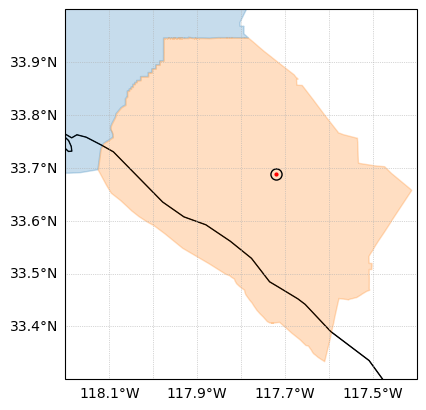

In [17]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.epsg(3857)})

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_geometries(LA_geom, crs=ccrs.epsg(3857), color="C0", alpha=0.25)
ax.add_geometries(orange_geom, crs=ccrs.epsg(3857), color="C1", alpha=0.25)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent([-118.2, -117.4, 33.3, 34])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(lon, lat, 'ok', markersize=8, transform=ccrs.PlateCarree(), mfc='none')
ax.plot(x, y, '.r', markersize=4)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],
                  ls=":", lw=0.5)
ax.set_title("");

### Step 2: Holistic / qualitative station evaluation
* downloading these stations manually into train_files, but should grab from AWS unless a better way to read nc files from AWS...

In [37]:
# phase 2 look at full timeseries for flags -- grabbing clean version, not qaqc version to build out
# alternatively.... some of these files may be very large and we should avoid reading in all because of memory concerns

# for stn in event_stns:
#     want to pull out all flags noted, frequency of flags of time record 

In [39]:
# read a single station in
stn = xr.open_dataset('/Users/hector/Downloads/CIMIS_75.nc')
stn

<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) float64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [40]:
def id_all_flags(ds):
    '''Prints all unique values of all eraqaqc flags'''
    ds_vars = list(stn.keys())
    qc_vars = [i for i in ds_vars if '_eraqc' in i]
    if len(qc_vars) == 0:
        print('Station has no eraqc variables -- please double check that this station has completed QA/QC!')
    else:
        for var in qc_vars:
            print(var, np.unique(ds[var].data))

In [41]:
id_all_flags(stn)

tas_eraqc [11. 23. 25. 26. nan]
pr_eraqc [nan]
hurs_eraqc [nan]
rsds_eraqc [11. nan]
sfcWind_eraqc [27. 28. 29. nan]
sfcWind_dir_eraqc [15. nan]
elevation_eraqc [nan]
tdps_derived_eraqc [11. 12. 13. 23. 25. 26. nan]
pvp_derived_eraqc [nan]


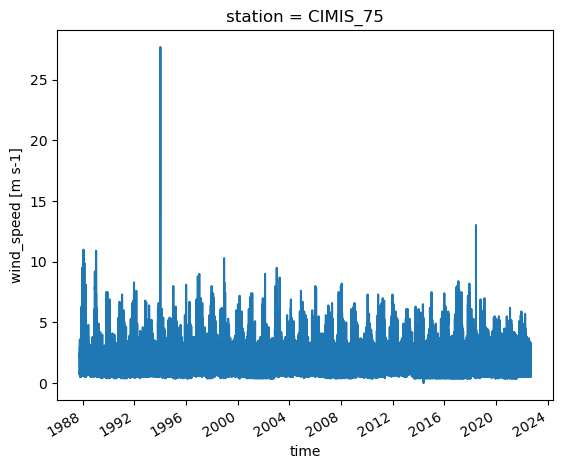

In [42]:
# look at full timeseries for holistic view
stn.sfcWind.plot()

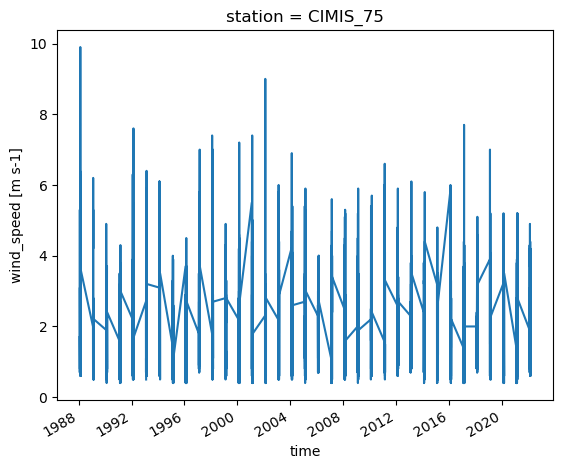

In [43]:
# look at timeseries of all months of that event (e.g., all februaries) to understand climatological signal?
month = [2]
stn_monthly_clim = stn.isel(time=stn.time.dt.month.isin(month))

stn_monthly_clim.sfcWind.plot()

# hmm not so useful, perhaps a climatology of the month to compare with the event

In [44]:
# look at timeseries during event for flags
# decision: do we add a few days prior/after event end date to evaluate "event anomaly"? i think this may be useful
# santa ana event was 2/16/1988 to 2/19/1988; including +/- 1 week
event_start_date = '1988-02-09'
event_end_date = '1988-02-26'

# subset for event period of time
event = stn.sel(time=slice(event_start_date, event_end_date))

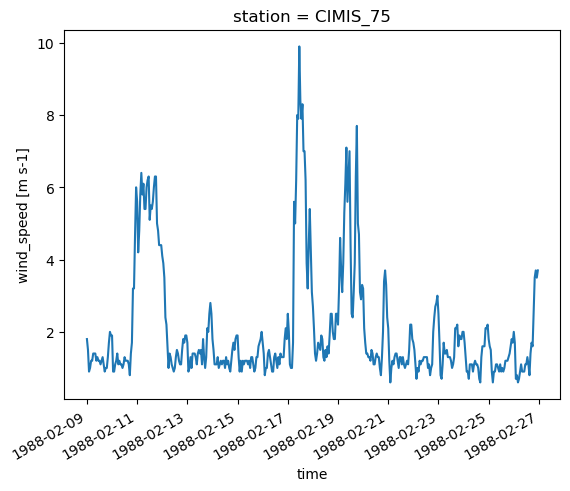

In [45]:
# just grabbing a single var for the event itself
event.sfcWind.plot()

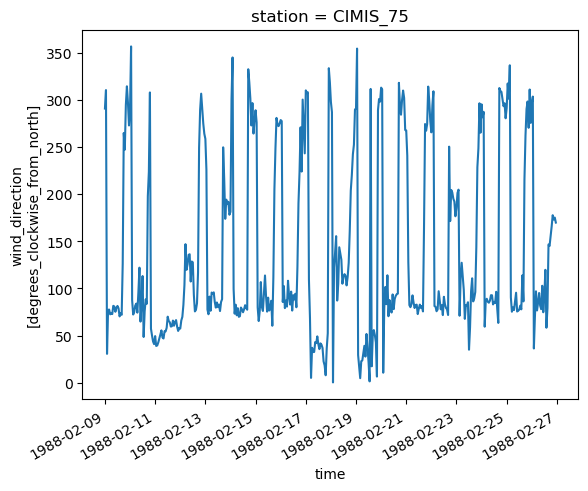

In [46]:
event.sfcWind_dir.plot()

In [47]:
# look at all stations (5-20 view) for the event to qualitatively get a sense of how stations did during the event with regards to qaqc flags

### Step 3: Validate against other QA/QC'd data
* GHCNh data

### Clone GHCNh library

```bash
git clone https://github.com/Eagle-Rock-Analytics/GHCNh.git
cd GHCNh
branch="origin/ghcnh_class_dev"
git branch --track ${branch##origin/} $branch

#### Import GHCNh class

```python
from GHCNh.GHCNh_lib import GHCNh
ghcnh = GHCNh()```

#### Plot GHCNh stations

```python
wecc_terr = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"
t = gpd.read_file(wecc_terr).iloc[0].geometry  ## Read in terrestrial WECC shapefile.
m = gpd.read_file(wecc_mar).iloc[0].geometry   ## Read in marine WECC shapefile.

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_geometries(m, crs=ccrs.PlateCarree(), color="C0", alpha=0.25)
ax.add_geometries(t, crs=ccrs.PlateCarree(), color="C1", alpha=0.25)
# ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent([-130, -100, 28, 52])
ax.plot(ghcnh.stations_df['longitude'], ghcnh.stations_df['latitude'], 
        marker='.', lw=0, c="k", ms=2, label="WECC")
tmp = ghcnh.stations_df[~ghcnh.stations_df['is_in_wecc']]
ax.plot(tmp['longitude'], tmp['latitude'], 
        marker='.', lw=0, c="red", ms=2, label="Not WECC")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],
                  ls=":", lw=0.5)
ax.set_title("GHCNh stations");
```

#### Select WECC 

``` python
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
print(id)
ghcnh.read_data_from_url(id=id)
ghcnh.station_data
```

#### Plot some variables from the read station

``` python
fig,ax = plt.subplots()

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title(id);
```

In [40]:
from GHCNh.GHCNh_lib import GHCNh

ModuleNotFoundError: No module named 'GHCNh'

In [5]:
%%time
ghcnh = GHCNh(stations_local=False)
ghcnh.stations_df.head()

CPU times: user 1min 2s, sys: 887 ms, total: 1min 3s
Wall time: 1min 6s


,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,url,is_in_wecc
0,ACL000BARA9,17.5910,-61.8210,5.0,TX,BARBUDA,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False
2,AFW00000472,43.0667,74.4667,637.0,TX,KYRGYZSTAN US MIL BISHKEK,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False
3,AQC00914594,-14.3333,-170.7667,42.4,AS,MALAELOA,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False
4,AQC00914902,-14.2728,-170.6922,80.8,AS,VAIPITO,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False


In [23]:
ghcnh.select_wecc()
ghcnh.stations_df

,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,url,is_in_wecc,geometry
38,CAW00025343,54.2500,-133.0500,41.1,BC,LANGARA,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-14811058.250 7217646.198)
238,USC00020080,32.3698,-112.8599,533.7,AZ,AJO,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-12563506.599 3811951.112)
239,USC00020487,35.1989,-112.4886,1546.9,AZ,ASH FORK 3,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-12522173.672 4190943.819)
240,USC00020808,33.4783,-109.7516,1848.6,AZ,BLACK RIVER PUMPS,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-12217492.226 3958963.741)
241,USC00021574,34.5397,-110.9155,2135.4,AZ,CHEVELON RANGER STATION,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-12347056.981 4101502.827)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5933,USW00094285,42.1667,-120.4000,1441.1,OR,LAKEVIEW LAKE CO AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13402866.692 5185983.096)
5934,USW00094290,47.6872,-122.2553,18.3,WA,SEATTLE SAND PT WFO,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13609397.743 6054972.932)
5935,USW00094297,48.2167,-122.6333,60.7,WA,COUPEVILLE NOLF,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13651476.510 6142982.009)
5936,USW00094298,45.6211,-122.6542,6.4,WA,VANCOUVER PEARSON AP,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,True,POINT (-13653803.088 5719836.749)


In [21]:
# ghcnh.stations_df.to_csv("GHCNh/processed_ghcnh_station_list.csv")
# ghcnh.stations_df.to_csv("processed_ghcnh_station_list.csv")
# ghcnh.stations_df.to_csv("../processed_ghcnh_station_list.csv")
# ghcnh.stations_df.to_csv("../../processed_ghcnh_station_list.csv")

In [24]:
%%time
id = ghcnh.stations_df['id'].iloc[0]
id

CPU times: user 211 µs, sys: 783 µs, total: 994 µs
Wall time: 997 µs


'CAW00025343'

In [25]:
ghcnh.read_data_from_url(id=id)

/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh/GHCNh_lib.py:134: DtypeWarning: Columns (12,18,24,30,42,49,51,60,66,76,77,79,81,82,83,85,87,106,107,109,111,125,127,129,139,141,143,145,147,148,149,151,153,157,159,160,161,163,165,169,171,172,173,175,177,181,183,191,193,195,227,229,231,232,234,237) have mixed types. Specify dtype option on import or set low_memory=False.
  self.station_data = pd.read_csv(url, sep='|')


In [27]:
ghcnh.station_data.head()

,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Report_Type,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID,time
0,CAW00025343,LANGARA,1954,1,1,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 09:00:00
1,CAW00025343,LANGARA,1954,1,1,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 21:00:00
2,CAW00025343,LANGARA,1954,1,2,3,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 03:00:00
3,CAW00025343,LANGARA,1954,1,2,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 09:00:00
4,CAW00025343,LANGARA,1954,1,2,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 21:00:00


In [56]:
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
id

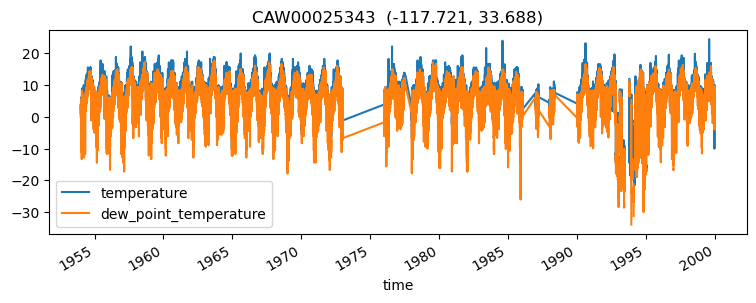

In [28]:
fig,ax = plt.subplots(figsize=(9,3))

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat));

In [51]:
# ghcnh.station_data.head()

In [10]:
ghcnh.convert_df_to_gpd()
ghcnh.stations_df.head()

,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,url,is_in_wecc,geometry
0,ACL000BARA9,17.5910,-61.8210,5.0,TX,BARBUDA,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False,POINT (-6881882.240 1989730.842)
1,ACW00011647,17.1333,-61.7833,19.2,,ST JOHNS,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False,POINT (-6877685.496 1936347.478)
2,AFW00000472,43.0667,74.4667,637.0,TX,KYRGYZSTAN US MIL BISHKEK,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False,POINT (8289595.125 5322129.784)
3,AQC00914594,-14.3333,-170.7667,42.4,AS,MALAELOA,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False,POINT (-19009662.088 -1612483.159)
4,AQC00914902,-14.2728,-170.6922,80.8,AS,VAIPITO,,,,NaN,https://www.ncei.noaa.gov/oa/global-historical...,False,POINT (-19001368.786 -1605532.889)


In [20]:
gpd.overlay(ghcnh.stations_df, target_counties, how="intersection") 

,id,latitude,longitude,elevation,state,name,gsn_flag,hcn,crn_flag,wmo_id,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,USC00041194,34.1866,-118.3480,199.6,CA,BURBANK VALLEY PUMP PLANT,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13174439.096 4053885.452)
1,USC00046624,34.5883,-118.0938,796.1,CA,PALMDALE,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13146141.682 4108072.558)
2,USI0000K3A6,34.3700,-118.5700,427.0,CA,NEWHALL,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13199152.023 4078592.851)
3,USI0000KGXA,34.5639,-117.6750,920.5,CA,GRAY BUTTE FLD,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13099521.079 4104773.694)
4,USL000ICAC1,34.0080,-118.5000,2.0,CA,SANTA MONICA PIER,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13191359.659 4029876.281)
5,USL000OHBC1,33.7200,-118.2720,2.0,CA,LOS ANGELES,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13165978.815 3991266.547)
6,USL000PFXC1,33.7480,-118.2680,3.0,CA,LOS ANGELES PIER F,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13165533.537 3995014.567)
7,USL000PRJC1,33.7330,-118.1860,3.0,CA,LONG BEACH PIER J,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13156405.339 3993006.547)
8,USW00003122,33.8017,-118.3419,27.4,CA,TORRANCE AP,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13173760.048 4002206.159)
9,USW00003157,33.7500,-118.2333,4.3,CA,LONG BEACH NAVAL STN,,,,NaN,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13161670.751 3995282.330)


Each station “psv” file is made up of a unique identifier and time step followed by
- **30 variable fields**:
    * Each with 5 associated metadata/attribute fields
- All fields are “pipe” separated (pipe = “|”).
- Each of the variables and metadata fields are described with explicit names in a header line at the beginning of each station file.
    * Note that the header length is quite long and is also pipe delimited.
 


**Each station record is indexed to:** 
- a single GHCN Station_ID
- Station_name
- Latitude
- Longitude
- Elevation

which was extracted from metadata provided by one or more data sources.

**Each observation is also indexed to:**

- a single Year, Month, Day, Hour and Minute in Coordinated Universal Time (UTC).

Following the identifier, coordinates and time stamp for the observation, there are **38 sets of observations for 38 variables** and their accompanying metadata/attributes as follows:

- **variable** (see section IV, Table 1)
- **variable_Measurement_Code** (see section V, Table 2)
- **variable_Quality_Code** (see section VI, Table 3)
- **variable_Report_Type** (see section VII, Table 4)
- **variable_Source_Code** (see section VII, Table 5)
- **variable_Source_Station_ID** (original identifier provided in the data source)

Where variable refers to the list of variables in Table 1 and their units. 

A list of potential Measurement_Codes by variable type is provided in Table2. 

The list of Quality_Codes is provided in Table 3. 

Table 4 provides the list of possible report types. 

All column numbers and names are provided in Appendix Table A1.


#### <u>Table 1: Elements/Variables</u>

<div style="display: inline-block">
    
| Variable   |      Description      |  Units |
|---|---|---|
| temperature | <div style="width: 40em;">  2 meter (circa) Above Ground Level Air (dry bulb) Temperature </div>| 0C to tenths |
| dew_point_temperature | <div style="width: 40em;">  Dew Point Temperature </div>| 0C to tenths |
| station_level_pressure | <div style="width: 40em;"> The pressure that is observed at a specific elevation and is the true barometric pressure of a location. It is the pressure exerted by the atmosphere at a point as a result of gravity acting upon the "column" of air that lies directly above the point </div> | hPa |
| wind_direction | <div style="width:  40em;"> Wind Direction from true north using compass directions (e.g. 360 = true north, 180 = south, 270 = west, etc.). Note: A direction of “000” is given for calm winds </div>| whole degrees |
| wind_speed | <div style="width:  40em;"> Wind Speed </div> | meters per second |
| wind_gust | <div style="width:  40em;"> Peak short duration (usually < 20 seconds) wind speed (meters per second) that exceeds the wind_speed average </div> |  |
| precipitation | <div style="width:  40em;"> total liquid precipitation (rain or melted snow) for past hour; a “T” in the measurement code column indicates a trace amount of precipitation </div> | millimeters |
| relative_humidity | <div style="width:  40em;"> Relative humidity is calculated from air (dry bulb) temperature and dew point temperature </div> | whole percent |
| wet_bulb_temperature | <div style="width:  40em;"> Present weather observation; MW1 - MW3 is sourced from manual reports; up to 3 observations per report </div> | 0C to tenths |
| pres_wx_MW1 | <div style="width:  40em;"> Present weather observation; MW1 - MW3 is sourced from manual reports; up to 3 observations per report </div> | code |
| pres_wx_MW2 | <div style="width:  40em;"> see above </div> | code |
| pres_wx_MW3 | <div style="width:  40em;"> see above </div> | code |
| pres_wx_AU1 | <div style="width:  40em;"> weather observation; AU1 - AU3 is sourced from automated ASOS/AWOS sensors; up to 3 observations per report </div> | code |
| pres_wx_AU2 | <div style="width:  40em;"> see above </div> | code |
| pres_wx_AU3 | <div style="width:  40em;"> see above </div> | code |
| pres_wx_AW1 | <div style="width:  40em;"> Present weather observation; AW1 - AW3 is sourced from automated sensors; up to 3 observations per report </div> | code |
| pres_wx_AW2 | <div style="width:  40em;"> see above </div> | code |
| pres_wx_AW3 | <div style="width:  40em;"> see above </div> | code |
| snow_depth | <div style="width:  40em;"> depth of snowpack on the ground </div> | centimeters/m |
| visibility | <div style="width:  40em;"> horizontal distance at which an object can be seen and identified </div> | kilometers |
| altimeter | <div style="width:  40em;"> the pressure "reduced" to mean sea level using the temperature profile of the "standard" atmosphere, which is representative of average conditions over the United States at 40 degrees north latitude </div> | millibars/hPa |
| pressure_3hr_change | <div style="width:  40em;"> change in atmospheric pressure measured at the beginning and end of a three hour period; accompanied by tendency code in measurement code field </div> | millibars/hPa |
| sky_cover_1 | <div style="width:  40em;"> Fraction of total celestial dome with sky coverage; defines a layer in oktas (i.e. eights) or tenths of sky covered by cloud; up to 3 observations </div> | code |
| sky_cover_2 | <div style="width:  40em;"> see above </div> | code |
| sky_cover_3 | <div style="width:  40em;"> see above </div> | (see Table X for code definitions) |
| sky_cover_baseht_1 | <div style="width:  40em;"> Discrete cloud base heights at lowest point of layer; up to 3 vertical layers can be reported; clear skies reported as a single layer </div> | meters |
| sky_cover_baseht_2 | <div style="width:  40em;"> see above </div> |  |
| sky_cover_baseht_3 | <div style="width:  40em;"> see above </div> |  |
| precipitation_3_hour | <div style="width:  40em;"> 3-hour total liquid precipitation (rain or melted snow) accumulation from FM12/SYNOP reports; a “T” in the measurement code column   indicates a trace amount of precipitation. Accumulations can be reported over 3, 6, 9, 12, 15, 18, 21 and 24 hours. </div> | millimeters |
| precipitation_6_hour | <div style="width:  40em;"> see above </div> |  |
| precipitation_9_hour | <div style="width:  40em;"> see above </div> |  |
| precipitation_12_hour | <div style="width:  40em;"> see above </div> |  |
| precipitation_15_hour | <div style="width:  40em;"> see above </div> |  |
| precipitation_18_hour | <div style="width:  40em;"> see above </div> |  |
| precipitation_21_hour | <div style="width:  40em;"> see above </div> |  |
| precipitation_24_hour | <div style="width:  40em;"> see above </div> |  |
| remarks | <div style="width:  40em;"> Hourly Remarks present the raw surface observation data in the original format  encoded into ICAO-standardized METAR (FM15) or FM12 (SYNOP), FM16 (SPECI) etc format for global dissemination. Further information on decoding these observations can be found in the Federal Meteorological Handbook (FMH) No. 1, Surface Weather Observations & Reports. </div> |  |

</div>

#### VI. List of Quality Check codes

#### <u> Table 3: QC (code varies by source) </u>

<div style="width: 60em;">
A general set of quality control checks is applied to a subset of variables after all sources are integrated into a set of unique period of record station files. These checks are described in Dunn et al. (2016). In addition, GHCNh preserves the Quality Control information of its component sources. The set of general flags that apply to the integrated set of sources and the variables temperature, dew_point_temperature, station_level_pressure, sea_level_pressure, wind_direction, and wind_speed
</div>

**The list of codes include:**
<div style="display: inline-block">
    
|    |    |
|---|---|
|  
| "L" : "0," | # failed Logical consistency |
| "o" : "1," | # outlier check |
| "F" : "2," | # Frequent value check |
| "U" : "3," | # diUrnal inconsistency check "D" : "4,", # Distribution 1 |
| "d" : "5," | # distribution 2 |
| "W" : "6," | # World records exceedance "K" : "7,", # StreaK check |
| "C" : "8," | # Climatological outlier |
| "T" : "9," | # Timestamp issue |
| "S" : "10," | # Spike check |
| "h" : "11," | # humidity |
| "V" : "12," | # Variance |
| "w" : "13," | # winds |
| "N" : "14," | # Neighbor comparison outlier "E" : "15,", # clEan up |
| "p" : "16," | # pressure |
| "H" : "17," | # High flag rate |

</div>

#### The Legacy Codes for Sources 313, 314, 315, 322, 335, 343, 344, 345, 346 include 0 = Passed gross limits check
<div style="display: inline-block">
    
|    |    |
|---|---|
|  
| 1 |  Passed all quality control checks |
| 2 | Suspect |
| 3 | Erroneous |
| 4 | Passed gross limits check, data originate from an NCEI data source |
| 5 | Passed all quality control checks, data originate from an NCEI data source |
| 6 | Suspect, data originate from an NCEI data source |
| 7 | Erroneous, data originate from an NCEI data source |
| 9 | Passed gross limits check if element is present |
| A | Data value flagged as suspect, but accepted as good value. |
| U | Data value replaced with edited value. |
| P | Data value not originally flagged as suspect, but replaced by validator. |
| I | Data value not originally in data, but inserted by validator. |
| M | Manual change made to value based on information provided by NWS or FAA. |
| C | <div style="width:  60em;"> Temperature and dew point received from Automated Weather Observing Systems (AWOS) are reported in whole degrees Celsius. Automated QC flags these values, but they are accepted as valid. </div>|
| R | Data value replaced with value computed by NCEI software. |

</div>

#### And Legacy Codes for Sources: 220, 221, 222, 223, 347, 348 include 0 Not Checked 
<div style="display: inline-block">
    
|    |    |
|---|---|
| 1 | Good |
| 2 | Suspect |
| 3 | Erroneous |
| 4 | Calculated |
| 5 | Removed |

</div>

#### Derived variables (relative humidity and wet-bulb temperature) can have the following QC flags: 
<div style="display: inline-block">
    
|    |    |
|---|---|
| o | Out of range (relative humidity only - with values < 1 or > 100) |
| f | Suspect or Error flags for 1 or more of the input measurements |

</div>

### Table A1: Columns/Headers

<div style="display: inline-block">
<div style="display: flex; justify-content: space-between;">
<div style="width: 45%;">
  
| Col# | Header |
|---|---|
| 1 | Station_ID |
| 2 | Station_name |
| 3 | Year |
| 4 | Month |
| 5 | Day |
| 6 | Hour |
| 7 | Minute |
| 8 | Latitude |
| 9 | Longitude |
| 10 | Elevation |
</div>
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 11 | temperature |
| 12 | temperature_Measurement_Code |
| 13 | temperature_Quality_Code |
| 14 | temperature_Report_Type |
| 15 | temperature_Source_Code |
| 16 | temperature_Source_Station_ID |
| 17 | dew_point_temperature |
| 18 | dew_point_temperature_Measurement_Code |
| 19 | dew_point_temperature_Quality_Code |
| 20 | dew_point_temperature_Report_Type |
| 21 | dew_point_temperature_Source_Code |
| 22 | dew_point_temperature_Source_Station_ID |
</div>
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 23 | station_level_pressure |
| 24 | station_level_pressure_Measurement_Code |
| 25 | station_level_pressure_Quality_Code |
| 26 | station_level_pressure_Report_Type |
| 27 | station_level_pressure_Source_Code |
| 28 | station_level_pressure_Source_Station_ID |
| 29 | sea_level_pressure |
| 30 | sea_level_pressure_Measurement_Code |
| 31 | sea_level_pressure_Quality_Code |
| 32 | sea_level_pressure_Report_Type |
| 33 | sea_level_pressure_Source_Code |
| 34 | sea_level_pressure_Source_Station_ID |
</div>
</div>
</div>

<div style="display: inline-block">
<div style="display: flex; justify-content: space-between;">
<div style="width: 45%;">
  
| Col# | Header |
|---|---|
| 35 | wind_direction |
| 36 | wind_direction_Measurement_Code |
| 37 | wind_direction_Quality_Code |
| 38 | wind_direction_Report_Type |
| 39 | wind_direction_Source_Code |
| 40 | wind_direction_Source_Station_ID |
| 41 | wind_speed |
| 42 | wind_speed_Measurement_Code |
| 43 | wind_speed_Quality_Code |
| 44 | wind_speed_Report_Type |
| 45 | wind_speed_Source_Code |
| 46 | wind_speed_Source_Station_ID |
| 47 | wind_gust |
| 48 | wind_gust_Measurement_Code |
| 49 | wind_gust_Quality_Code |
| 50 | wind_gust_Report_Type |
| 51 | wind_gust_Source_Code |
| 52 | wind_gust_Source_Station_ID |
</div>
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 53 | precipitation |
| 54 | precipitation_Measurement_Code |
| 55 | precipitation_Quality_Code |
| 56 | precipitation_Report_Type |
| 57 | precipitation_Source_Code |
| 58 | precipitation_Source_Station_ID |
| 59 | relative_humidity |
| 60 | relative_humidity_Measurement_Code |
| 61 | relative_humidity_Quality_Code |
| 62 | relative_humidity_Report_Type |
| 63 | relative_humidity_Source_Code |
| 64 | relative_humidity_Source_Station_ID |
| 65 | wet_bulb_temperature |
| 66 | wet_bulb_temperature_Measurement_Code |
| 67 | wet_bulb_temperature_Quality_Code |
| 68 | wet_bulb_temperature_Report_Type |
| 69 | wet_bulb_temperature_Source_Code |
| 70 | wet_bulb_temperature_Source_Station_ID |
</div>
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 71 | pres_wx_MW1 |
| 72 | pres_wx_MW1_Measurement_Code |
| 73 | pres_wx_MW1_Quality_Code |
| 74 | pres_wx_MW1_Report_Type |
| 75 | pres_wx_MW1_Source_Code |
| 76 | pres_wx_MW1_Source_Station_ID |
| 77 | pres_wx_MW2 |
| 78 | pres_wx_MW2_Measurement_Code |
| 79 | pres_wx_MW2_Quality_Code |
| 80 | pres_wx_MW2_Report_Type |
| 81 | pres_wx_MW2_Source_Code |
| 82 | pres_wx_MW2_Source_Station_ID |
| 83 | pres_wx_MW3 |
| 84 | pres_wx_MW3_Measurement_Code |
| 85 | pres_wx_MW3_Quality_Code |
| 86 | pres_wx_MW3_Report_Type |
| 87 | pres_wx_MW3_Source_Code |
| 88 | pres_wx_MW3_Source_Station_ID |
</div>
</div>
</div>

<div style="display: inline-block">
<div style="display: flex; justify-content: space-between;">
<div style="width: 45%;">
  
| Col# | Header |
|---|---|
| 89 | pres_wx_AU1 |
| 90 | pres_wx_AU1_Measurement_Code |
| 91 | pres_wx_AU1_Quality_Code |
| 92 | pres_wx_AU1_Report_Type |
| 93 | pres_wx_AU1_Source_Code |
| 94 | pres_wx_AU1_Source_Station_ID |
| 95 | pres_wx_AU2 |
| 96 | pres_wx_AU2_Measurement_Code |
| 97 | pres_wx_AU2_Quality_Code |
| 98 | pres_wx_AU2_Report_Type |
| 99 | pres_wx_AU2_Source_Code |
| 100 | pres_wx_AU2_Source_Station_ID |
| 101 | pres_wx_AU3 |
| 102 | pres_wx_AU3_Measurement_Code |
| 103 | pres_wx_AU3_Quality_Code |
| 104 | pres_wx_AU3_Report_Type |
| 105 | pres_wx_AU3_Source_Code |
| 106 | pres_wx_AU3_Source_Station_ID |
</div>
<div style="width: 45%;">
    
| Col# | Header |
|---|---|
| 107 | pres_wx_AW1 |
| 108 | pres_wx_AW1_Measurement_Code |
| 109 | pres_wx_AW1_Quality_Code |
| 110 | pres_wx_AW1_Report_Type |
| 111 | pres_wx_AW1_Source_Code |
| 112 | pres_wx_AW1_Source_Station_ID |
| 113 | pres_wx_AW2 |
| 114 | pres_wx_AW2_Measurement_Code |
| 115 | pres_wx_AW2_Quality_Code |
| 116 | pres_wx_AW2_Report_Type |
| 117 | pres_wx_AW2_Source_Code |
| 118 | pres_wx_AW2_Source_Station_ID |
| 119 | pres_wx_AW3 |
| 120 | pres_wx_AW3_Measurement_Code |
| 121 | pres_wx_AW3_Quality_Code |
| 122 | pres_wx_AW3_Report_Type |
| 123 | pres_wx_AW3_Source_Code |
| 124 | pres_wx_AW3_Source_Station_ID |
</div>
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 125 | snow_depth |
| 126 | snow_depth_Measurement_Code |
| 127 | snow_depth_Quality_Code |
| 128 | snow_depth_Report_Type |
| 129 | snow_depth_Source_Code |
| 130 | snow_depth_Source_Station_ID |
| 131 | visibility |
| 132 | visibility_Measurement_Code |
| 133 | visibility_Quality_Code |
| 134 | visibility_Report_Type |
| 135 | visibility_Source_Code |
| 136 | visibility_Source_Station_ID |
| 137 | altimeter |
| 138 | altimeter_Measurement_Code |
| 139 | altimeter_Quality_Code |
| 140 | altimeter_Report_Type |
| 141 | altimeter_Source_Code |
| 142 | altimeter_Source_Station_ID |
</div>
</div>
</div>

<div style="display: inline-block">
<div style="display: flex; justify-content: space-between;">
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 143 | pressure_3hr_change |
| 144 | pressure_3hr_change_Measurement_Code |
| 145 | pressure_3hr_change_Quality_Code |
| 146 | pressure_3hr_change_Report_Type |
| 147 | pressure_3hr_change_Source_Code |
| 148 | pressure_3hr_change_Source_Station_ID |
| 149 | sky_cover_1 |
| 150 | sky_cover_1_Measurement_Code |
| 151 | sky_cover_1_Quality_Code |
| 152 | sky_cover_1_Report_Type |
| 153 | sky_cover_1_Source_Code |
| 154 | sky_cover_1_Source_Station_ID |
| 155 | sky_cover_baseht_1 |
| 156 | sky_cover_baseht_1_Measurement_Code |
| 157 | sky_cover_baseht_1_Quality_Code |
| 158 | sky_cover_baseht_1_Report_Type |
| 159 | sky_cover_baseht_1_Source_Code |
| 160 | sky_cover_baseht_1_Source_Station_ID |
</div>
<div style="width: 45%;">
    
| Col# | Header |
|---|---|
| 161 | sky_cover_2 |
| 162 | sky_cover_2_Measurement_Code |
| 163 | sky_cover_2_Quality_Code |
| 164 | sky_cover_2_Report_Type |
| 165 | sky_cover_2_Source_Code |
| 166 | sky_cover_2_Source_Station_ID |
| 167 | sky_cover_baseht_2 |
| 168 | sky_cover_baseht_2_Measurement_Code |
| 169 | sky_cover_baseht_2_Quality_Code |
| 170 | sky_cover_baseht_2_Report_Type |
| 171 | sky_cover_baseht_2_Source_Code |
| 172 | sky_cover_baseht_2_Source_Station_ID |
| 173 | sky_cover_3 |
| 174 | sky_cover_3_Measurement_Code |
| 175 | sky_cover_3_Quality_Code |
| 176 | sky_cover_3_Report_Type |
| 177 | sky_cover_3_Source_Code |
| 178 | sky_cover_3_Source_Station_ID |
</div>
<div style="width: 45%;">
    
| Col# | Header |
|---|---|
| 179 | sky_cover_baseht_3 |
| 180 | sky_cover_baseht_3_Measurement_Code |
| 181 | sky_cover_baseht_3_Quality_Code |
| 182 | sky_cover_baseht_3_Report_Type |
| 183 | sky_cover_baseht_3_Source_Code |
| 184 | sky_cover_baseht_3_Source_Station_ID |
| 185 | precipitation_3_hour |
| 186 | precipitation_3_hour_Measurement_Code |
| 187 | precipitation_3_hour_Quality_Code |
| 188 | precipitation_3_hour_Report_Type |
| 189 | precipitation_3_hour_Source_Code |
| 190 | precipitation_3_hour_Source_Station_ID |
| 191 | precipitation_6_hour |
| 192 | precipitation_6_hour_Measurement_Code |
| 193 | precipitation_6_hour_Quality_Code |
| 194 | precipitation_6_hour_Report_Type |
| 195 | precipitation_6_hour_Source_Code |
| 196 | precipitation_6_hour_Source_Station_ID |
</div>
</div>
</div>

<div style="display: inline-block">
<div style="display: flex; justify-content: space-between;">
<div style="width: 45%;">

| Col# | Header |
|---|---|
| 197 | precipitation_9_hour |
| 198 | precipitation_9_hour_Measurement_Code |
| 199 | precipitation_9_hour_Quality_Code |
| 200 | precipitation_9_hour_Report_Type |
| 201 | precipitation_9_hour_Source_Code |
| 202 | precipitation_9_hour_Source_Station_ID |
| 203 | precipitation_12_hour |
| 204 | precipitation_12_hour_Measurement_Code |
| 205 | precipitation_12_hour_Quality_Code |
| 206 | precipitation_12_hour_Report_Type |
| 207 | precipitation_12_hour_Source_Code |
| 208 | precipitation_12_hour_Source_Station_ID |
| 209 | precipitation_15_hour |
| 210 | precipitation_15_hour_Measurement_Code |
| 211 | precipitation_15_hour_Quality_Code |
| 212 | precipitation_15_hour_Report_Type |
| 213 | precipitation_15_hour_Source_Code |
| 214 | precipitation_15_hour_Source_Station_ID |
</div>
<div style="width: 45%;">
    
| Col# | Header |
|---|---|
| 215 | precipitation_18_hour |
| 216 | precipitation_18_hour_Measurement_Code |
| 217 | precipitation_18_hour_Quality_Code |
| 218 | precipitation_18_hour_Report_Type |
| 219 | precipitation_18_hour_Source_Code |
| 220 | precipitation_18_hour_Source_Station_ID |
| 221 | precipitation_21_hour |
| 222 | precipitation_21_hour_Measurement_Code |
| 223 | precipitation_21_hour_Quality_Code |
| 224 | precipitation_21_hour_Report_Type |
| 225 | precipitation_21_hour_Source_Code |
| 226 | precipitation_21_hour_Source_Station_ID |
| 227 | precipitation_24_hour |
| 228 | precipitation_24_hour_Measurement_Code |
| 229 | precipitation_24_hour_Quality_Code |
| 230 | precipitation_24_hour_Report_Type |
| 231 | precipitation_24_hour_Source_Code |
| 232 | precipitation_24_hour_Source_Station_ID |
</div>
<div style="width: 45%;">
    
| Col# | Header |
|---|---|
| 233 | remarks |
| 234 | remarks_Measurement_Code |
| 235 | remarks_Quality_Code |
| 236 | remarks_Report_Type |
| 237 | remarks_Source_Code |
| 238 | remarks_Source_Station_ID |
</div>
</div>
</div>

In [20]:
# read in ghcnh data
## hector working on this

In [21]:
#

In [22]:
# initial test for identifying the event: large jumps on windspeed

In [37]:
def return_ghcn_vars(ghcn_df, input_var):
    '''
    Given an input variable, return GHCNh location variables and all relevant data variables,
    rather than utilizing the whole 240 cols, or having to know how ghcnh labels the cols.

    input_var must follow ERA naming scheme (tas, tdps, ps, pr, etc.)
    '''
    ghcnh_vars = pd.read_csv('ghcnh_data_headers.csv')

    # include station-ID, time, loc, elevation (cols 1-10)
    stn_info_cols = ['Station_ID', 'Station_name',
                     'Year','Month','Day','Hour','Minute',
                     'Latitude','Longitude','Elevation']
    
    var_cols = []
    if input_var == 'tas':
        varquery = 'temperature'
        
    elif input_var == 'tdps' or 'tdps_derived':
        varquery = 'dew_point_temperature'
        
    elif input_var == 'ps' or 'psl':
        varquery = 'station_level_pressure'
        
    elif input_var == 'sfcWind_dir':
        varquery = 'wind_direction'
        
    elif input_var == 'sfcWind':
        varquery = ['wind_speed', 'wind_gust']

    elif input_var == 'hurs':
        varquery = 'relative_humidity'
        
    elif input_var == 'rsds':
        print('GHCNh data does not have solar radiation data to evaluate against.')
        varquery = '' 
        
    elif input_var == 'pr' or input_var == 'pr_1h' or input_var == 'pr_5min':
        varquery = 'precipitation'

    var_cols = [i for i in ghcnh_vars if varquery in i]
    cols_to_return = stn_info_cols + var_cols
    return ghcn_df[[cols_to_return]]

In [39]:
return_ghcn_vars(ghcnh.station_data, 'tas')

NameError: name 'ghcnh' is not defined